<a href="https://colab.research.google.com/github/LorenzoKaufmann/crypto_forecast/blob/main/Collect_Data_from_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.4 MB/s eta 0:00:00


In [2]:
!pip install python-dotenv

##Import

In [3]:
import asyncpraw
import asyncprawcore
import dotenv
import os
import asyncio
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy.stats as stats
from google.colab import  drive
from asyncpraw import Reddit
import json

In [20]:
drive.mount('/drive', force_remount=True)
folder_path = '/drive/My Drive/Colab Notebooks/Crypto Project/Data/reddit_posts'
folder_path_daily_update = '/drive/My Drive/Colab Notebooks/Crypto Project/Data/reddit_posts/Daily_Update'


Mounted at /drive


In [25]:
dotenv.load_dotenv('/drive/My Drive/Colab Notebooks/Crypto Project/.env')
client_id_Reddit = os.getenv('client_id_Reddit')
client_secret_Reddit = os.getenv('client_secret_Reddit')
user_agent_Reddit = os.getenv('user_agent_Reddit')

##API Functions

In [27]:
async def get_reddit_instance():
    """
    Creates and returns an Async PRAW Reddit instance.
    """
    return asyncpraw.Reddit(
        client_id=client_id_Reddit,
        client_secret=client_secret_Reddit,
        user_agent=user_agent_Reddit,
    )

In [28]:
async def fetch_subreddit_data(reddit, subreddit_name, get_function=['top']):
    # Initialize the subreddit object
    print("Fetching subreddit data...")
    subreddit = await reddit.subreddit(subreddit_name)
    print("Subreddit data fetched.")

    # Dictionary to store unique submissions
    submissions_data = {}

    # Fetch functions to call
    fetch_methods = {
        'hot': subreddit.hot,
        'new': subreddit.new,
        'top': subreddit.top,
        'controversial': subreddit.controversial,
        'rising': subreddit.rising,
        }

    if get_function != 'all':
        fetch_methods = {k: v for k, v in fetch_methods.items() if k in get_function}
    # Iterate through each fetch method and collect submissions
    for fetch_name, fetch in fetch_methods.items():
        # Make sure to await the asynchronous generator
        if fetch_name == 'top':
          kwargs = {'limit': 5000,
                    'time_filter':'week'}
        else:
          kwargs = {'limit': 5000}
        async for submission in fetch(**kwargs):
            # Use submission ID to ensure uniqueness
            if submission.id in submissions_data:
              fetch_name_new = fetch_name + '_' + submissions_data[submission.id]['fetch_method']
              submissions_data[submission.id]['fetch_method'] = fetch_name_new
            else:
              submissions_data[submission.id] = {
                  'title': submission.title,
                  'score': submission.score,
                  'author': str(submission.author),
                  'url': submission.url,
                  'created_utc': submission.created_utc,
                  'text': submission.selftext,
                  'num_comments': submission.num_comments,
                  'subreddit': subreddit_name,
                  'fetch_method': fetch_name
              }

    return submissions_data


In [29]:
async def fetch_posts(subreddit_name, time_filter='all', get_function='top', limit=10):
    """
    Asynchronously fetch the top posts from a specified subreddit within a given time frame.

    Parameters:
    - subreddit_name: str, the name of the subreddit (e.g., 'Python')
    - time_filter: str, the time filter to apply ('day', 'week', 'month', 'year', 'all')
    - limit: int, the number of posts to retrieve

    Returns:
    - List of dictionaries with details about each post.
    """
    reddit = await get_reddit_instance()
    try:
        # subreddit = await reddit.subreddit(subreddit_name)
        data = await fetch_subreddit_data(reddit, subreddit_name,
                                          get_function=get_function)
        return data

    except asyncprawcore.exceptions.RequestException as e:
        print("Request error:", e)
        return None
    except asyncprawcore.exceptions.NotFound:
        print(f"Subreddit '{subreddit_name}' not found.")
        return None
    except asyncpraw.exceptions.AsyncPRAWException as e:
        print("PRAW exception:", e)
        return None
    finally:
        # Clean up: Ensure Reddit instance is closed properly
        await reddit.close()
        print("Connection to Reddit closed.")

#Run here to get latest Posts

In [30]:
# Define an asynchronous main function to run the script
async def main():
    subreddit_name = 'CryptoCurrency'
    get_function = 'all'
    posts = await fetch_posts(subreddit_name, get_function=get_function,limit=1000)
    date = str(pd.Timestamp.today().date()).replace('-','_')
    filename = f'reddit_posts_{get_function}_{date}.json'
    if posts:
      if os.path.exists(folder_path_daily_update):
        with open(os.path.join(folder_path_daily_update, filename), 'w') as file:
          json.dump(posts, file, indent=4)
      else:
        print(f"Folder '{folder_path_daily_update}' does not exist.")
    else:
        print("No posts retrieved or an error occurred.")

# Run the asynchronous main function
if __name__ == "__main__":
    await main()

Fetching subreddit data...
Subreddit data fetched.
Connection to Reddit closed.


##Read data via **JSON**

In [31]:
def read_json_data(folder_path, get_function='all'):
  days_list = [f[17:-5] for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))]
  print(f'List of Days: {days_list}')
  all_posts = pd.DataFrame(columns=['index', 'title', 'score', 'text', 'author', 'url',
                                    'num_comments', 'subreddit', 'fetch_method'])
  for day in days_list:
    filename = f'reddit_posts_{get_function}_{day}.json'
    posts_df = pd.read_json(os.path.join(folder_path, filename),  orient='index')
    posts_df['created_utc'] = pd.to_datetime(posts_df['created_utc'], unit='s')
    posts_df = posts_df.reset_index().set_index('created_utc')
    if all_posts.empty:
      all_posts = posts_df
    else:
      all_posts = pd.concat([all_posts, posts_df])
  all_posts = all_posts.drop_duplicates(subset='index', keep='first')
  return all_posts

all_posts = read_json_data(folder_path_daily_update, get_function='all')

List of Days: ['2024_11_22', '2024_11_23', '2024_11_25', '2024_11_26', '2024_11_27', '2024_11_29', '2024_12_03', '2024_12_04', '2024_12_11', '2024_12_16', '2025_07_20']


### only for test and plots

In [32]:
test_case = False
if test_case:
  date = str(pd.Timestamp.today().date()).replace('-','_')
  date = "2024_11_20"
  get_function = 'all'
  filename = f'reddit_posts_{get_function}_{date}.json'

  posts_df = pd.read_json(os.path.join(folder_path_daily_update, filename),  orient='index')

  posts_df['created_utc'] = pd.to_datetime(posts_df['created_utc'], unit='s')
  posts_df = posts_df.reset_index().set_index('created_utc')

  print(posts_df.columns)
  duplicates = posts_df[posts_df.duplicated(subset='index', keep='first')]
  total_duplicates = posts_df.duplicated().sum()
  posts_df = posts_df.drop_duplicates()

##Plot Routine

In [45]:
def counting_posts_plot(posts_df, resample_intervall="D", style='bar',
                        variable="count", from_="", to_=""):
  resampling_frequencies = {
    'B': 'Business day',
    'C': 'Custom business day (user-defined)',
    'D': 'Day',
    'W': 'Weekly',
    'ME': 'Month',
    'SM': 'Semi-month (15th and end of month)',
    'BM': 'Business month ',
    'CBM': 'Custom business month',
    'MS': 'Month start',
    'SMS': 'Semi-month start (1st and 15th)',
    'BMS': 'Business month start',
    'CBMS': 'Custom business month start',
    'Q': 'Quarter',
    'BQ': 'Business quarter',
    'QS': 'Quarter start',
    'BQS': 'Business quarter start',
    'A': 'Year end',
    'BA': 'Business year end',
    'AS': 'Year start',
    'BAS': 'Business year start',
    'BH': 'Business hour',
    'H': 'Hourly',
    'T' or 'min': 'Minutely',
    'S': 'Secondly',
    'L' or 'ms': 'Millisecond',
    'U' or 'us': 'Microsecond',
    'N': 'Nanosecond'
}
  if from_ != "" and to_ != "":
    from_ = pd.to_datetime(from_, format="%d-%m-%Y")
    to_ = pd.to_datetime(to_, format="%d-%m-%Y")
    posts_df = posts_df.loc[(posts_df.index >= from_) & (posts_df.index <= to_)]
  # Resampling to get daily counts
  if variable == 'count':
    daily_counts = posts_df.resample(resample_intervall).size()
    var = daily_counts.values
  elif variable == 'score':
    daily_counts = posts_df.resample(resample_intervall)['score'].mean()
    var = daily_counts.values
  elif variable == 'num_comments':
    daily_counts = posts_df.resample(resample_intervall)['num_comments'].mean()
    var = daily_counts.values
  else:
    print('Wrong Variable')
  # Plotting
  # plt.figure(figsize=(12, 6))
  fig, ax = plt.subplots(figsize=(12, 6))

  if style == 'line':
    sns.lineplot(x=daily_counts.index, y=var)
  elif style == 'bar':
    sns.barplot(x='dt_idx', y='count', data=daily_counts, color='#4c72b0', edgecolor='black')
  else:
    print('Wrong Style')

  plt.xlabel('Date')
  plt.ylabel(f'{variable} of Posts')
  plt.title(f'{variable} of Posts Per {resampling_frequencies[resample_intervall]}')
  plt.xticks(rotation=0, ha='right', fontsize=10)
  plt.yticks(fontsize=10)

  # plt.minorticks_on()
  plt.grid(which='major', color='gray', linestyle='-', linewidth=0.75)
  plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

  major_tick = {'D':mdates.DayLocator,
                'ME':mdates.MonthLocator,
                'Y':mdates.YearLocator}

  ax.xaxis.set_major_locator(major_tick[resample_intervall]())  # Set major ticks to daily
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

  plt.tight_layout()
  # plt.show()
  daily_counts = daily_counts.to_frame()
  daily_counts.columns = ["count"]
  # daily_counts.rename(columns={"0": "count"}, inplace=True)

  plt.figure(figsize=(12, 6))
  bars = plt.bar(resampled_df.index, resampled_df["count"], color="skyblue")

  # Add numbers on top of each bar
  for bar in bars:
      yval = int(bar.get_height())
      plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), ha="center", va="bottom")

  # Customize plot
  plt.title("Bar Plot with Counts", fontsize=16)
  plt.xlabel("Date", fontsize=12)
  plt.ylabel("Count", fontsize=12)
  plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.show()
  return daily_counts

##Statistics

In [44]:
# Print start and end date of the DataFrame
print("Start Date:", all_posts.index.min().strftime('%d-%m-%Y'))
print("End Date:", all_posts.index.max().strftime('%d-%m-%Y'))

# Print statistics for each column
print("\nDataFrame Statistics:")
print(all_posts.describe(include='all'))

Start Date: 02-01-2014
End Date: 20-07-2025

DataFrame Statistics:
          index                                      title         score  \
count      4997                                       4997   4997.000000   
unique     4997                                       4996           NaN   
top     1lqsht2  Questions for the Indian Crypto Community           NaN   
freq          1                                          2           NaN   
mean        NaN                                        NaN   1584.958175   
std         NaN                                        NaN   3814.252195   
min         NaN                                        NaN      0.000000   
25%         NaN                                        NaN      0.000000   
50%         NaN                                        NaN     20.000000   
75%         NaN                                        NaN    392.000000   
max         NaN                                        NaN  53906.000000   

       author       

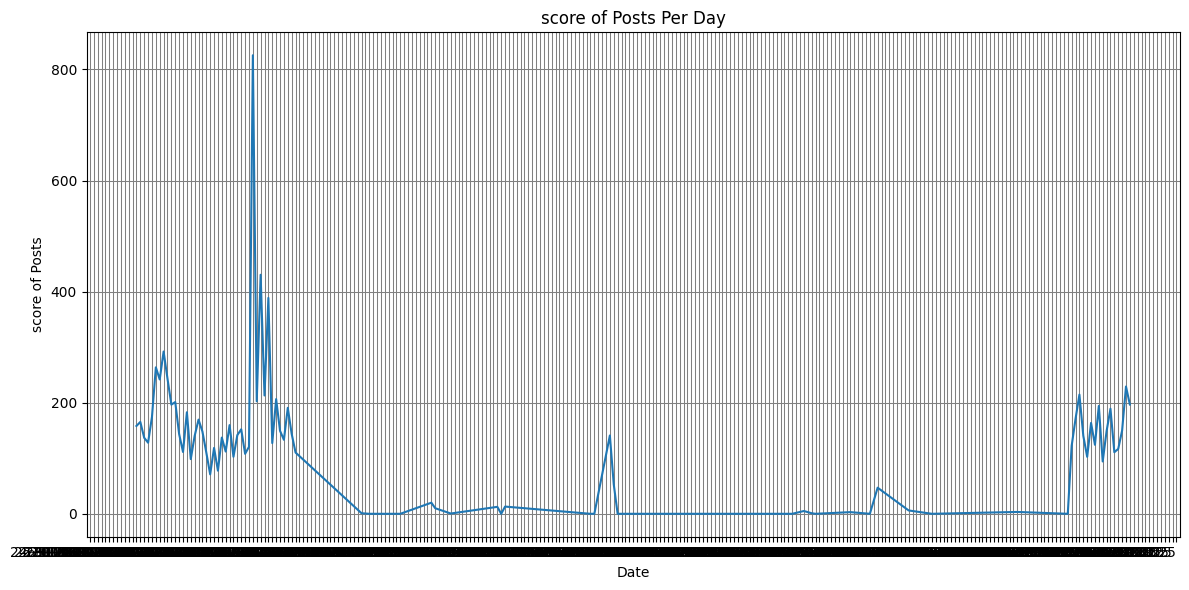

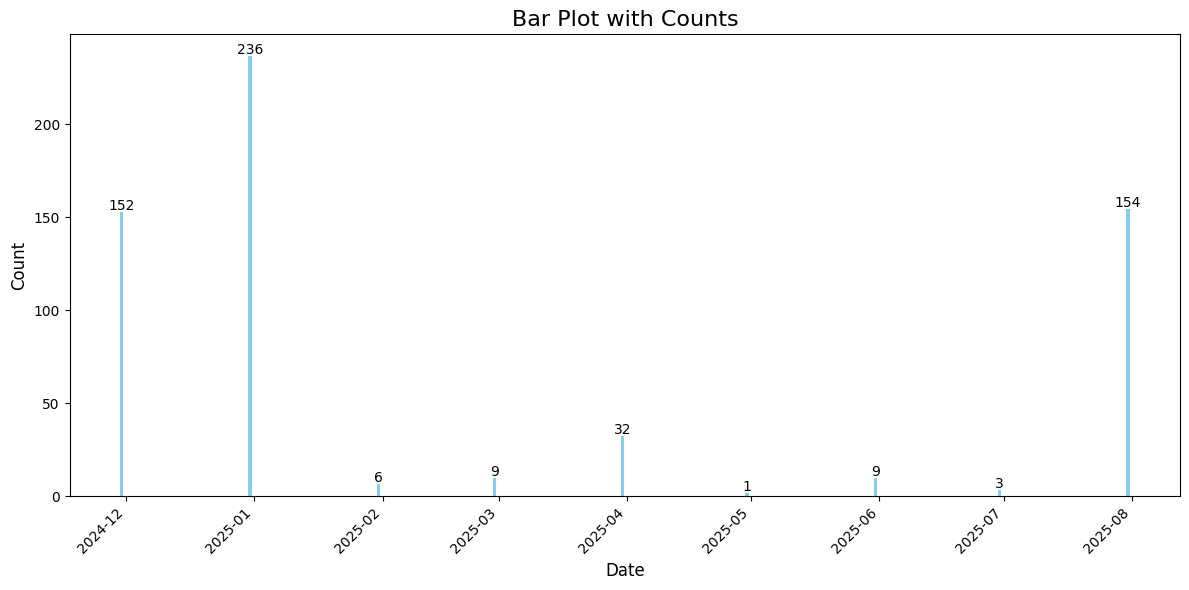

In [47]:
if test_case:
  today_date = str(pd.Timestamp.today().date().strftime('%d-%m-%Y'))
  resampled_df = counting_posts_plot(all_posts, resample_intervall='D',
                                    style='line', variable='score',
                                    from_="01-11-2024", to_=today_date)

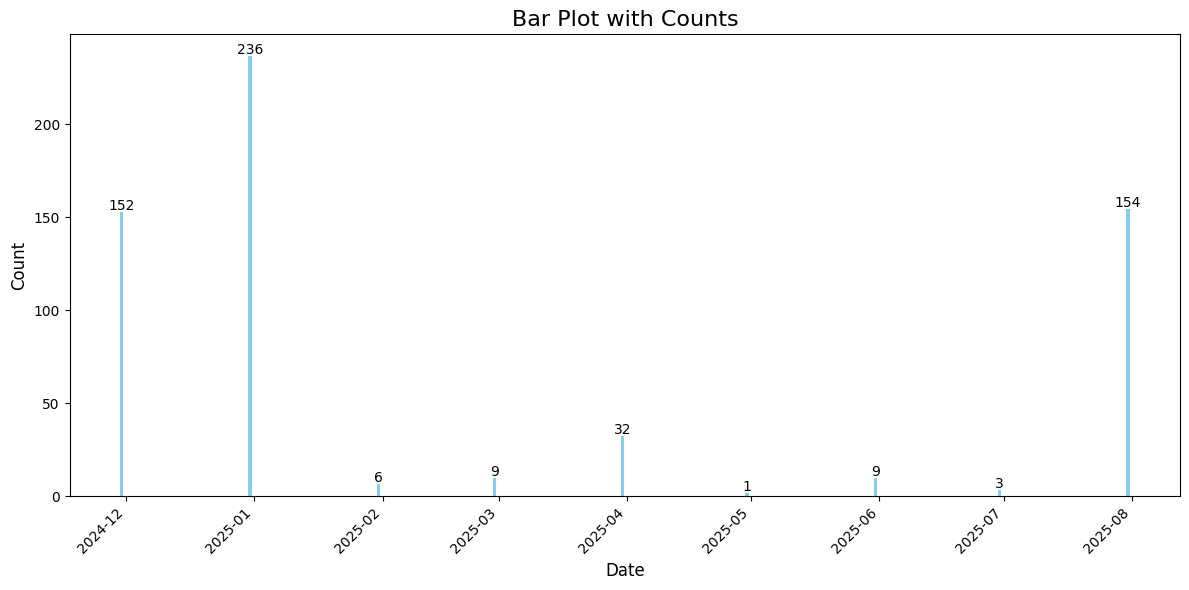